# Convolutional Neural Network (CNN) from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
2. [Loading Data](#2-loading-data)
3. [CNN Architecture](#3-cnn-architecture)
    - [Convolutional Layer](#convolutional-layer)
    - [Pooling Layer](#pooling-layer)
    - [Fully Connected Layer](#fully-connected-layer)
4. [Flatten Layer](#4-flatten-layer)
5. [Activation Function](#5-activation-function)
    - [Rectified Linear Unit (ReLU)](#rectified-linear-unit-relu)
    - [ReLU Derivative](#relu-derivative)
6. [Output Layer](#6-output-layer)
7. [Loss Function](#7-loss-function)
    - [Cross-Entropy Loss](#cross-entropy-loss)
8. [Evaluation Metric](#8-evaluation-metric)
    - [Accuracy](#accuracy)
9. [CNN Model](#9-cnn-model)
    - [Architecture](#architecture)
10. [Training and Evaluation](#10-training-and-evaluation)
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from numpy.typing import NDArray
from typing import Tuple

## 1. Introduction
A Convolutional Neural Network (CNN) is a specialised deep learning architecture designed to process and interpret visual data, such as images. CNNs are the backbone of modern image recognition, object detection, and other computer vision tasks.

## 2. Loading Data
The MNIST dataset (handwritten digits) is loaded, normalised to values between 0 and 1 then reshaped to include a channel dimension (for grayscale images, the value is 1). Labels are one-hot encoded for classification.

In [2]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
images, labels = mnist.data.reshape(-1, 28, 28), mnist.target.astype(np.uint8)

# Standard train/test split = 80%:20%
split_idx = int(len(images)*0.8)
X_train, y_train = images[:split_idx], labels[:split_idx]
X_test, y_test = images[split_idx:], labels[split_idx:]

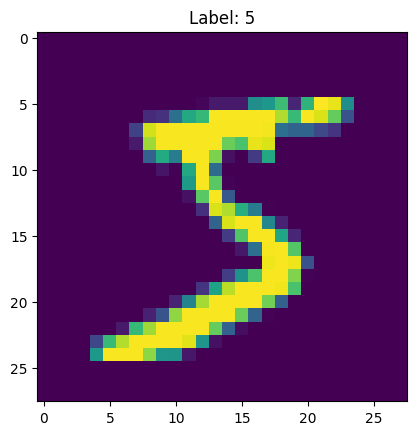

In [3]:
plt.title(f'Label: {labels[0]}')
plt.imshow(X_train[0])
plt.show()

- `image` -> Normalised (values between $0$ and $1$).
- `labels` -> One-hot encoded ($5$ will be encoded as $[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$)

In [4]:
# Preprocessing function
def preprocess_data(images: NDArray[np.int64], labels: NDArray[np.int64]) -> Tuple[NDArray[np.float64], NDArray[np.int64]]:
    """
    Preprocess image and label data for neural network training.

    Performs:
    1. Image normalisation (0-255 -> 0.0-1.0).
    2. Channel dimension addition.
    3. One-hot encoding of labels.

    Args:
        images: Input image array of shape (n_samples, height, width).
        labels: Integer label array of shape (n_samples,).

    Returns:
        Tuple containing:
        - Processed images: shape (n_samples, height, width, 1).
        - One-hot encoded labels: shape (n_samples, num_classes).
    """
    images = images.astype(float) / 255.0
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = np.eye(num_classes)[labels]
    return images, labels


X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

## 3. CNN Architecture
CNNs are composed of three main types of layers, each with a specific role.

- Convolutional Layer
- Pooling Layer
- Fully-Connected Layer

### Convolutional Layer
Convolutional Layer applies leanable filters (kernels) that slide over the input image to produce feature maps. Each filter is a small matrix (e.g., $3 \times 3$ or $5 \times 5$) of randomly initialised weights, and it detects patterns (edges, textures, shapes) in the local regions of the image. In this layer, we can specify two hyperparameters depending on our tasks:

- **Stride**: The number of steps the filter moves at each slide. With $\geq 2$ strides, we can reduce the spatial dimensions for computation (downsampling).
- **Padding**: Adding borders (zeros) around the input to control the size of the output.
    - **Valid padding**: No padding, output size is reduced.
    - **Same Padding**: Padding ensures the output size matches the input size.

For each spatial location, the filter computes a weighted sum of pixel values (dot product), plus a bias, and outputs the result as a new pixel in the feature map. The first output is a dot product of is the top left $3 \times 3 $ matrix of the input and the filter, calculated as $0.37 \times 0.57 + 0.95 \times (-0.60) + 0.73 \times 0.03 + \dots + 0.83 \times 0.90 = -0.28$.

<center><img src="_img/conv2d_1.png"/></center>

Then, the filter moves by 1 column to calculate the second output value:

<center><img src="_img/conv2d_2.png"/></center>

We repeat this process until we obtain all the values for the output matrix (Forward Propagation).

During the training process, gradients of the loss function with respect to the filter weights and biases are computed via backpropagation. These gradients are used to update the filters, allowing the neural network to learn optimal feature extractors.

In [5]:
class Conv2D:
    """
    2D Convolutional Layer implementation.
    """

    def __init__(self, num_filters: int, filter_size: int, input_shape: int) -> None:
        """
        Initialise convolutional layer parameters.

        Args:
            num_filters: Number of filters/kernels in layer
            filter_size: Spatial dimensions of filters (filter_size x filter_size)
            input_shape: Shape of input tensor (height, width, channels)
        """
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.input_shape = input_shape
        self.filters = np.random.randn(
            num_filters, filter_size, filter_size, input_shape[-1]) * 0.1
        self.biases = np.zeros(num_filters)

    def forward(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Perform forward pass through convolutional layer.

        Computes:
            output[b, i, j, f] = ∑∑∑ (input_region * filter) + bias.

        Args:
            input: Input tensor of shape (batch_size, height, width, in_channels).

        Returns:
            Output feature maps of shape (batch_size, out_height, out_width, num_filters).
        """
        self.input = input
        batch_size, in_h, in_w, in_c = input.shape
        out_h = in_h - self.filter_size + 1
        out_w = in_w - self.filter_size + 1
        self.output = np.zeros((batch_size, out_h, out_w, self.num_filters))

        for i in range(out_h):
            for j in range(out_w):
                region = input[:, i:i+self.filter_size,
                               j:j+self.filter_size, :]
                self.output[:, i, j, :] = np.tensordot(
                    region, self.filters, axes=([1, 2, 3], [1, 2, 3])
                ) + self.biases
        return self.output

    def backward(self, grad: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute gradients during backpropagation.

        Calculates:
        1. Gradient w.r.t filters.
        2. Gradient w.r.t biases.
        3. Gradient w.r.t input (using full convolution).

        Args:
            grad: Gradient from next layer of shape (batch_size, out_h, out_w, num_filters).

        Returns:
            Gradient w.r.t input of shape (batch_size, in_h, in_w, in_channels).
        """
        batch_size, out_h, out_w, num_filters = grad.shape
        in_h, in_w, in_c = self.input.shape[1], self.input.shape[2], self.input.shape[3]

        # Gradient w.r.t filters
        grad_filters = np.zeros_like(self.filters)
        for f in range(num_filters):
            for i in range(out_h):
                for j in range(out_w):
                    region = self.input[:, i:i +
                                        self.filter_size, j:j+self.filter_size, :]
                    grad_filters[f] += np.sum(region * grad[:, i, j, f]
                                              [:, None, None, None], axis=0)

        # Gradient w.r.t biases
        grad_biases = np.sum(grad, axis=(0, 1, 2))

        # Gradient w.r.t input (vectorised implementation)
        grad_input = np.zeros_like(self.input)
        padded_grad = np.pad(grad, ((0, 0), (self.filter_size-1, self.filter_size-1),
                                    (self.filter_size-1, self.filter_size-1), (0, 0)))
        flipped_filters = np.flip(
            self.filters, axis=(1, 2)).transpose(1, 2, 0, 3)

        for i in range(in_h):
            for j in range(in_w):
                region = padded_grad[:, i:i +
                                     self.filter_size, j:j+self.filter_size, :]
                # Vectorised computation
                grad_input[:, i, j, :] = np.sum(
                    region[:, :, :, :, None] *
                    flipped_filters[None, :, :, :, :],
                    axis=(1, 2, 3)
                )

        self.grad_filters = grad_filters
        self.grad_biases = grad_biases
        return grad_input

    def update(self, learning_rate: float) -> None:
        """
        Update layer parameters using gradient descent.

        Args:
            learning_rate: Step size for parameter updates.
        """
        self.filters -= learning_rate * self.grad_filters
        self.biases -= learning_rate * self.grad_biases

### Pooling Layer
Convolutional layers are often followed by a pooling layer to reduce the spatial dimensions (heights/widths) of feature maps while retaining important information. It slides a window over the feature map and replaces the each region with a single summary value, which is the maximum (or average) value in each region for max pooling.

In [6]:
class MaxPooling:
    """
    Max Pooling Layer implementation.
    """

    def __init__(self, pool_size: int) -> None:
        """
        Initialise max pooling layer.

        Args:
            pool_size: Window size for pooling (pool_size x pool_size).
        """
        self.pool_size = pool_size

    def forward(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Perform forward pass through max pooling layer.

        Args:
            input: Input tensor of shape (batch_size, height, width, channels).

        Returns:
            Downsampled output of shape (batch_size, out_h, out_w, channels).
        """
        self.input = input
        batch_size, h, w, c = input.shape
        out_h = h // self.pool_size
        out_w = w // self.pool_size
        output = np.zeros((batch_size, out_h, out_w, c))
        self.mask = np.zeros_like(input)

        for i in range(out_h):
            for j in range(out_w):
                h_start, h_end = i*self.pool_size, (i+1)*self.pool_size
                w_start, w_end = j*self.pool_size, (j+1)*self.pool_size
                region = input[:, h_start:h_end, w_start:w_end, :]
                output[:, i, j, :] = np.max(region, axis=(1, 2))

                # Create mask for backpropagation
                mask_region = (region == output[:, i, j, :][:, None, None, :])
                self.mask[:, h_start:h_end, w_start:w_end, :] = mask_region
        return output

    def backward(self, grad: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Distribute gradients during backpropagation.

        Args:
            grad: Gradient from next layer of shape (batch_size, out_h, out_w, channels).

        Returns:
            Gradient w.r.t input of shape (batch_size, height, width, channels).
        """
        grad_input = np.zeros_like(self.input)
        batch_size, out_h, out_w, c = grad.shape

        for i in range(out_h):
            for j in range(out_w):
                h_start, h_end = i*self.pool_size, (i+1)*self.pool_size
                w_start, w_end = j*self.pool_size, (j+1)*self.pool_size

                # Distribute gradient to max positions
                grad_region = grad[:, i:i+1, j:j+1, :]
                grad_region = np.repeat(grad_region, self.pool_size, axis=1)
                grad_region = np.repeat(grad_region, self.pool_size, axis=2)

                mask_region = self.mask[:, h_start:h_end, w_start:w_end, :]
                grad_input[:, h_start:h_end, w_start:w_end,
                           :] += grad_region * mask_region

        return grad_input

### Fully Connected Layer
In this layer, each neuron is connected to every element of the preceding layer's output. It performs a linear transformation (dot product with weights + bias), and passes the result to the next layer. For a single neuron:

\begin{align*}
    z = \sum_{i=1}^{b}x_{i}w_{i} + b
\end{align*}

where:
- $x_{i}$: Inputs from the previous layer.
- $w_{i}$: Weights for each input.
- $b$: Bias term.
- $z$: Pre-activation value (weighted sum + bias).

Fully connected layer computes this $z$ value for each neuron.

In [7]:
class Dense:
    """
    Fully Connected (Dense) Layer implementation.
    """

    def __init__(self, input_size: int, output_size: int) -> None:
        """
        Initialise dense layer parameters.

        Args:
            input_size: Number of input features.
            output_size: Number of output neurons.
        """
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros(output_size)

    def forward(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Perform forward pass: output = input·W + b.

        Args:
            input: Input tensor of shape (batch_size, input_size).

        Returns:
            Output tensor of shape (batch_size, output_size).
        """
        self.input = input
        return np.dot(input, self.weights) + self.biases

    def backward(self, grad: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute gradients during backpropagation.

        Args:
            grad: Gradient from next layer of shape (batch_size, output_size).

        Returns:
            Gradient w.r.t input of shape (batch_size, input_size).
        """
        grad_input = np.dot(grad, self.weights.T)
        self.grad_weights = np.dot(self.input.T, grad)
        self.grad_biases = np.sum(grad, axis=0)
        return grad_input

    def update(self, learning_rate: float) -> None:
        """
        Update layer parameters using gradient descent.

        Args:
            learning_rate: Step size for parameter updates.
        """
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases

## 4. Flatten Layer
Neural networks often have convolutional or pooling layers that output 2D or 3D feature maps. Fully connected layers, however, expect 1D output. The flatten layers bridges this gap by reshaping multidimentional input data into a one-dimensional vector.

In [8]:
class Flatten:
    """
    Flatten Layer implementation.
    """

    def forward(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Flatten input tensor to 2D matrix.

        Args:
            input: Input tensor of shape (batch_size, *spatial_dims, channels).

        Returns:
            Flattened output of shape (batch_size, features).
        """
        self.input_shape = input.shape
        return input.reshape(input.shape[0], -1)

    def backward(self, grad: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Reshape gradient to original input shape.

        Args:
            grad: Gradient from next layer of shape (batch_size, features).

        Returns:
            Gradient w.r.t input of original shape (batch_size, *spatial_dims, channels).
        """
        return grad.reshape(self.input_shape)

## 5. Activation Function
After the convolutional layers and the dense layers, an activation function is applied to introduce non-linearity, allowing the neural network to learn complex patterns.

### Rectified Linear Unit (ReLU)
ReLU is computationally efficient and it mitigates vanishing gradient, but it may cause 'Dying ReLU' problem where neurons can get stuck at 0.

\begin{align*}
\sigma(Z) = \text{max}(0, Z)
\end{align*}


### ReLU Derivative

\begin{align*}
    \sigma'(Z) =
    \begin{cases}
    1 & \text{if } Z > 0 \\
    0 & \text{otherwise}
    \end{cases}
\end{align*}

In [9]:
class ReLU:
    """
    Rectified Linear Unit (ReLU) Activation Layer.
    """

    def forward(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Apply element-wise ReLU activation: output = max(0, input).

        Args:
            input: Input tensor of any shape.

        Returns:
            Activated output of same shape as input.
        """
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute gradient of ReLU: grad * (input > 0).

        Args:
            grad: Gradient from next layer.

        Returns:
            Gradient w.r.t input of same shape.
        """
        return grad * (self.input > 0)

## 6. Output Layer
The output layer with a softmax activation function assigns probabilities to multiple classes. The softmax function transforms the raw scores (logits) of the output layer into probabilities, ensuring that they are non-negative and their sum equals 1.

For a vector of logits $Z = [z_1, z_2, ..., z_k]$, the softmax function is:

\begin{align*}
    \sigma(Z_i) = \dfrac{e(z_{i})}{\sum^{k}_{j=1}e(z_j)} \text{ for } i=1, 2, ..., k
\end{align*}

where:
- $\sigma(Z_i)$: Predicted probability of the $i$-th class.
- $z_{i}$: Logit (raw score) for the $i$-th class.
- $k$: Number of classes.

In [10]:
def softmax(x: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Compute softmax activation for classification.

    Args:
        x: Input logits of shape (batch_size, num_classes).

    Returns:
        Probability distribution over classes of shape (batch_size, num_classes).
    """
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

## 7. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True lavel for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} - \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{i})}
\end{align*}

In [11]:
def cross_entropy_loss(y_pred: NDArray[np.float64], y_true: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Compute categorical cross-entropy loss.

    Args:
        y_pred: Predicted probabilities of shape (batch_size, num_classes).
        y_true: Ground truth one-hot labels of shape (batch_size, num_classes).

    Returns:
        Scalar loss value.
    """
    m = y_true.shape[0]
    log_probs = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)])
    return np.sum(log_probs) / m

## 8. Evaluation Metric
### Accuracy
Accuracy is the most common evaluation metric for classification problems, representing the percentage of correct predictions out of total predictions. It provides a simple measure of how often the classifier makes correct predictions across all classes.

In [12]:
def accuracy(y_pred: NDArray[np.int64], y_true: NDArray[np.int64]) -> NDArray[np.float64]:
    """
    Compute classification accuracy.

    Args:
        y_pred: Predicted class probabilities of shape (batch_size, num_classes).
        y_true: Ground truth one-hot labels of shape (batch_size, num_classes).

    Returns:
        Accuracy score between 0.0 and 1.0.
    """
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

## 9. CNN Model
The following `ConvNet` class is a basic implementation of a Convolutional Neural Network. It defines a sequential neural network structure with the following main components:

- **Convolutional Layer (Conv2D)**: Extracts spatial features from input images.
- **Activation Layer (ReLU)**: Introduces non-linearity to the network.
- **Pooling Layer (MaxPooling)**: Reduces spatial dimensions to decrease computation and avoid overfitting.
- **Flatten Layer**: Converts 2D feature maps into 1D vectors for feeding into dense layers.
- **Dense Layers**: Fully connected layers for classification.
- **Forward, Backward**, and Update Methods: Handle forward propagation, backpropagation, and parameter updates.

<figure style="text-align: center;">
  <img src="_img/cnn.png">
  <figcaption>
    <em>
      <a href="https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148" target="_blank">
        Source: Understanding of Convolutional Neural Network (CNN) — Deep Learning
      </a>
    </em>
  </figcaption>
</figure>

### Architecture
1. Convolutional Layer
2. ReLU Activation
3. Max Pooling Layer
4. Flatten Layer
5. First Dense Layer
6. ReLU Activation
7. Second Dense Layer

In [13]:
class ConvNet:
    """
    Convolutional Neural Network architecture for image classification.
    """

    def __init__(self):
        """
        Initialise CNN layers with fixed architecture.
        """
        self.conv1 = Conv2D(num_filters=8, filter_size=3,
                            input_shape=(28, 28, 1))
        self.relu1 = ReLU()
        self.pool1 = MaxPooling(pool_size=2)
        self.flatten = Flatten()
        self.dense1 = Dense(input_size=13*13*8, output_size=128)
        self.relu2 = ReLU()
        self.dense2 = Dense(input_size=128, output_size=10)
        self.layers = [
            self.conv1, self.relu1, self.pool1,
            self.flatten, self.dense1, self.relu2, self.dense2
        ]

    def forward(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Perform forward pass through all layers.

        Args:
            x: Input image tensor of shape (batch_size, 28, 28, 1).

        Returns:
            Output logits of shape (batch_size, 10).
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad: NDArray[np.float64]) -> None:
        """
        Backpropagate gradients through all layers.

        Args:
            grad: Gradient from loss function.
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def update_params(self, learning_rate: float) -> None:
        """
        Update all trainable parameters in the network.

        Args:
            learning_rate: Step size for parameter updates.
        """
        for layer in self.layers:
            if hasattr(layer, 'update'):
                layer.update(learning_rate)

## 10. Training and Evaluation

In [14]:
# Training Setup
epochs = 3
batch_size = 64
learning_rate = 0.01

# Initialise model
model = ConvNet()

# Training loop
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Forward pass
        logits = model.forward(X_batch)
        y_pred = softmax(logits)
        loss = cross_entropy_loss(y_pred, y_batch)

        # Backward pass
        grad = (y_pred - y_batch) / batch_size
        model.backward(grad)
        model.update_params(learning_rate)

        # Print metrics
        if i % 6400 == 0:
            acc = accuracy(y_pred, y_batch)
            print(
                f"Epoch {epoch+1}, Batch {i//batch_size}: Loss={loss:.4f}, Accuracy={acc:.4f}")

# Evaluation
test_pred = softmax(model.forward(X_test))
test_acc = accuracy(test_pred, y_test)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Epoch 1, Batch 0: Loss=2.3489, Accuracy=0.0938
Epoch 1, Batch 100: Loss=1.6772, Accuracy=0.6094
Epoch 1, Batch 200: Loss=0.7494, Accuracy=0.8438
Epoch 1, Batch 300: Loss=0.5635, Accuracy=0.8594
Epoch 1, Batch 400: Loss=0.3581, Accuracy=0.9062
Epoch 1, Batch 500: Loss=0.4058, Accuracy=0.8125
Epoch 1, Batch 600: Loss=0.2573, Accuracy=0.9375
Epoch 1, Batch 700: Loss=0.3851, Accuracy=0.8750
Epoch 1, Batch 800: Loss=0.3646, Accuracy=0.8750
Epoch 2, Batch 0: Loss=0.3489, Accuracy=0.9062
Epoch 2, Batch 100: Loss=0.2353, Accuracy=0.9062
Epoch 2, Batch 200: Loss=0.2377, Accuracy=0.9531
Epoch 2, Batch 300: Loss=0.3985, Accuracy=0.9062
Epoch 2, Batch 400: Loss=0.1746, Accuracy=0.9219
Epoch 2, Batch 500: Loss=0.3212, Accuracy=0.9062
Epoch 2, Batch 600: Loss=0.1669, Accuracy=0.9375
Epoch 2, Batch 700: Loss=0.3434, Accuracy=0.8750
Epoch 2, Batch 800: Loss=0.2680, Accuracy=0.9062
Epoch 3, Batch 0: Loss=0.2508, Accuracy=0.9219
Epoch 3, Batch 100: Loss=0.1892, Accuracy=0.9219
Epoch 3, Batch 200: Loss=0

## 11. References

1. ANDRADA. (2020). *How I taught myself Deep Learning: Vanilla NNs*. <br>
https://www.kaggle.com/code/andradaolteanu/how-i-taught-myself-deep-learning-vanilla-nns/comments

1. Arseny Turin. (2020). *Neural Network From Scratch*. <br>
https://github.com/arsenyturin/Neural-Network-From-Scratch

1. Bot Academy. (2021). *Neural Networks Explained from Scratch using Python* [YouTube Video]. <br>
https://youtu.be/9RN2Wr8xvro

1. Cole Stryker and Dave Bergmann. (2024). *What is backpropagation?* <br>
https://www.ibm.com/think/topics/backpropagation

1. Futurology — An Optimistic Future. (2020). *Convolutional Neural Networks Explained (CNN Visualized)*. <br>
https://youtu.be/pj9-rr1wDhM

1. GeeksforGeeks. (2025). *Backpropagation in Neural Network*. <br>
https://www.geeksforgeeks.org/machine-learning/backpropagation-in-neural-network/

1. Haroon Khan. (2024). *A beginner's builde to: Vanilla Neural Networks*.<br>
https://www.linkedin.com/pulse/beginners-guide-vanilla-neural-networks-haroon-khan-qurjf/

1. IBM. (2021). *What is a neural network?* [YouTube Video] <br>
https://www.ibm.com/think/topics/neural-networks

1. IBM Technology. (2022). *Neural Networks Explained in 5 minutes* [YouTube Video]. <br>
https://youtu.be/jmmW0F0biz0

1. IBM Technology. (2021). *What are Convolutional Neural Networks (CNNs)?* [YouTube Video]. <br>
https://youtu.be/QzY57FaENXg

1. IBM Technology. (2023). *What is Back Propagation* [YouTube Video]. <br>
https://youtu.be/S5AGN9XfPK4

1. Michael Nielsen. (2019). *Using neural nets to recognize handwritten digits*. <br>
http://neuralnetworksanddeeplearning.com/chap1.html

1. Nitish Gupta. (2023). *Building VanillaNN: A Simplified Neural Network Framework from Scratch in Python*. <br>
https://blog.guptanitish.com/building-vanillann-a-simplified-neural-network-framework-from-scratch-in-python-c82f39071ee0

1. The Independent Code. (2021). *Convolutional Neural Network from Scratch | Mathematics & Python Code* [YouTube Video]. <br>
https://youtu.be/Lakz2MoHy6o

1. 3Blue1Brown. (2022). *But what is a convolution?* [YouTube Video]. <br>
https://youtu.be/KuXjwB4LzSA

1. 3Blue1Brown. (2017). *But what is a neural network? | Deep learning chapter 1* [YouTube Video]. <br>
https://youtu.be/aircAruvnKk

1. 3Blue1Brown. (2017). *Gradient descent, how neural networks learn | Deep Learning Chapter 2* [YouTube Video]. <br>
https://youtu.be/IHZwWFHWa-w

1. 3Blue1Brown. (2017). *Backpropagation, intuitively | Deep Learning Chapter 3* [YouTube Video]. <br>
https://youtu.be/Ilg3gGewQ5U

1. 3Blue1Brown. (2017). *Backpropagation calculus | Deep Learning Chapter 4* [YouTube Video]. <br>
https://youtu.be/tIeHLnjs5U8